![](https://drive.google.com/uc?export=view&id=1qjiUfddfUolPl_QsFIwP8jN1NSGxnhtS)



## Introduction

Long-horizon forecasting is challenging because of the *volatility* of the predictions and the *computational complexity*. To solve this problem we created the [N-HiTS](https://arxiv.org/abs/2201.12886) model and made the code available [NeuralForecast library](https://github.com/nixtla/neuralforecast). 

N-HiTS specializes its partial outputs in the different 〰 frequencies 〰 of the time series through hierarchical interpolation and multi-rate input
processing. 

In this notebook we show how to use N-HiTS on the [ETTm2](https://github.com/zhouhaoyi/ETDataset) benchmark dataset. This data set includes data points for 2 Electricity Transformers at 2 stations, including load, oil temperature.

We will show you how to load data, train, and perform automatic hyperparameter tuning, **to achieve SoTA performance**, outperforming even the latest Transformer architectures for a fraction of their computational cost (50x faster) ⚡🔥🚀.

Table of Contents
1.   [Installing NeuralForecast Library](#cell-1)
2.   [Load ETTm2 Data](#cell-2)
3.   [Define Hyperparameter Space](#cell-3)
4.   [Hyperparameter Tuning](#cell-4)
5.   [Evaluate Results](#cell-5)

If you are interested in talking about this or other time series models or want to sclae your models in production enviorments don't hesitate to send us an email at hello[at]nixtla.io or join our [slack community](https://join.slack.com/t/nixtlacommunity/shared_invite/zt-135dssye9-fWTzMpv2WBthq8NK0Yvu6A). 


<a name="cell-1"></a>
# 1. Installing Neuralforecast library

Run `pip install neuralforecast` to install all required dependencies.

In [1]:
%%capture
!pip install neuralforecast==0.1.0

In [2]:
import torch as t
import numpy as np
import pandas as pd
from hyperopt import hp
import matplotlib.pyplot as plt

import neuralforecast as nf
from neuralforecast.auto import NHITS
from neuralforecast.losses.numpy import mae, mse
from neuralforecast.data.datasets.long_horizon import LongHorizon

import logging
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

In [3]:
import timeit

class CodeTimer:
    def __init__(self, name=None, verbose=True):
        self.name = " '"  + name + "'" if name else ''
        self.verbose = verbose

    def __enter__(self):
        self.start = timeit.default_timer()

    def __exit__(self, exc_type, exc_value, traceback):
        self.took = (timeit.default_timer() - self.start)
        if self.verbose:
            print('Code block' + self.name + \
                  ' took:\t{0:.5f}'.format(self.took) + ' seconds')

This example will automatically run on GPUs if available. **Make sure** cuda is available. (If you need help to put this into production send us an email or join or community, we also offer a fully hosted solution)

In [4]:
t.cuda.is_available()

True

<a name="cell-2"></a>
# 2. Load ETTm2 Data

The `LongHorizon` class will automatically download the complete ETTm2 dataset and process it.

It return three Dataframes: `Y_df` contains the values for the target variables, `X_df` contains exogenous calendar features and `S_df` contains static features for each time-series (none for ETTm2). For this example we will only use `Y_df`.

If you want to use your own data just replace `Y_df`. Be sure to use a long format and have a simmilar structure than our data set.

In [5]:
# Change this to your own data to try the model
Y_df, _, _ = LongHorizon.load(directory='./', group='ETTm2')

# For this excercise we are going to take 20% of the DataSet
n_time = len(Y_df.ds.unique())
n_ts_val = int(.2 * n_time)
n_ts_test = int(.2 * n_time)

Y_df.head()

,unique_id,ds,y
0,HUFL,2016-07-01 00:00:00,-0.041413
1,HUFL,2016-07-01 00:15:00,-0.185467
2,HUFL,2016-07-01 00:30:00,-0.257495
3,HUFL,2016-07-01 00:45:00,-0.577510
4,HUFL,2016-07-01 01:00:00,-0.385501


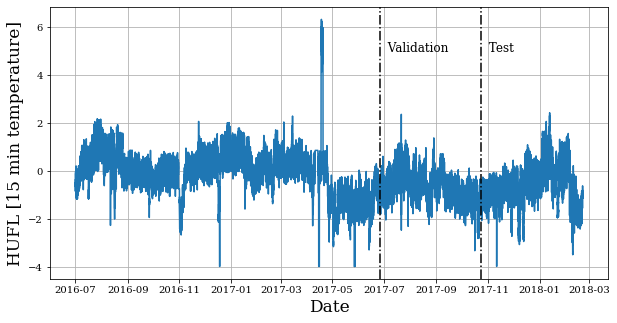

In [6]:
# We are going to plot the temperature of the transformer 
# and marking the validation and train splits
u_id = 'HUFL'
x_plot = pd.to_datetime(Y_df[Y_df.unique_id==u_id].ds)
y_plot = Y_df[Y_df.unique_id==u_id].y.values

x_val = x_plot[n_time - n_ts_val - n_ts_test]
x_test = x_plot[n_time - n_ts_test]

fig = plt.figure(figsize=(10, 5))
fig.tight_layout()

plt.plot(x_plot, y_plot)
plt.xlabel('Date', fontsize=17)
plt.ylabel('HUFL [15 min temperature]', fontsize=17)

plt.axvline(x_val, color='black', linestyle='-.')
plt.axvline(x_test, color='black', linestyle='-.')
plt.text(x_val, 5, '  Validation', fontsize=12)
plt.text(x_test, 5, '  Test', fontsize=12)

plt.grid()
plt.show()
plt.close()

<a name="cell-3"></a>
#3. Define Hyperparameter Space

The `auto.NHITS` class contains a pre-defined suggested hyperparameter space, built for the [Hyperopt library](https://iopscience.iop.org/article/10.1088/1749-4699/8/1/014008/meta).  This function only needs dataframe specific information such as the number of series and frequency. Feel free to play around with this space 😀. 

The parameter `n_time_out` is used to specify the desired forecasting horizon. To replicate results for other horizons from the paper, just change this value!

The N-HiTS `.space` attribute contains a suggested [hyperparameter space](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/auto.py#L63-#L135) ⬅.

In [7]:
n_time_out = 96 # 24hrs = 4 * 15 min.

model = nf.auto.NHITS(horizon=n_time_out)

You can override the N-HiTS search `.space` for each hyperparameter.

Notice that *1000 Stochastic Gradient Steps* are enough to achieve SoTA performance.

In [8]:
model.space['max_steps'] = hp.choice('max_steps', [1000])

Refer to http://hyperopt.github.io/hyperopt/ for more information on the different space options, such as lists and continous intervals.

<a name="cell-4"></a>
#4. Hyperparameter Tuning

The function `hyperopt_tunning` will perform the automatic hyperparameter optimization using the `Hyperopt` library for any of our implemented models, on the specified space, on any dataframes `Y_df` and with custom validation and test losses.

This function will split the data in `Y_df` based on the number of timestamps for the validation and test sets, specified with `ds_in_val` and `ds_in_test`. Each configuration will be trained on the train split, evaluated on the validation and test sets with the desired loss functions.

Use the `hyperopt_max_evals` parameter to change the number of configurations explored (5 is enough for achieving SoTA performance, but more iterations will further improve results).

In [9]:
# %%capture
with CodeTimer('Hyperopt Time: '):
    model.fit(Y_df=Y_df, 
              X_df=None,                             # Exogenous variables
              S_df=None,                             # Static variables
              hyperopt_steps=5,                      # Using 5 hyperopt steps
              n_ts_val=n_ts_val,                     # ETTm2's validation set
              n_ts_test=n_ts_test,                   # ETTm2's test set
              results_dir='./results/autonhits',
              save_trials=True,
              loss_function_val=nf.losses.numpy.mae, # MSE, QL, MQL, sMAPE ...
              loss_functions_test={'mae':nf.losses.numpy.mae,
                                  'mse':nf.losses.numpy.mse},
              return_test_forecast=True,
              verbose=False)

  0%|          | 0/5 [00:00<?, ?it/s, best loss: ?]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:448: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"



100%|██████████| 5/5 [02:55<00:00, 35.08s/it, best loss: 0.24214735627174377]
Code block 'Hyperopt Time: ' took:	177.31291 seconds


<a name="cell-5"></a>
#5. Evaluate Results


The auto.NHITS contains a `.trials` attribute. For each configuration explored, it will return the validation loss, hyperparameters (model config or `mc` key), run time and test loss.

If the `return_forecasts` flag is set to `True`, the `.trials` attribute will also contain forecasts for the test set.

In [10]:
trials = model.trials
trials.trials[0]['result'].keys()

dict_keys(['loss', 'mc', 'run_time', 'status', 'test_losses', 'forecasts_test'])

We then select the optimal run based on the validation loss, available using `trials.losses()`.

In [11]:
# Best validation hyperparameter configuration
best_run = np.argmin(trials.losses())
print("="*26+' Best  Hyperparameters '+"="*26)
print(pd.Series(trials.trials[best_run]['result']['mc']))

========================== Best  Hyperparameters ==========================
activation                                                             ReLU
batch_normalization                                                   False
batch_size                                                                1
complete_windows                                                       True
constant_n_blocks                                                         3
constant_n_layers                                                         3
constant_n_mlp_units                                                   1024
dropout_prob_theta                                                        0
early_stop_patience                                                      10
eval_freq                                                                50
frequency                                                               15T
idx_to_sample_freq                                                        1
initializati

Finally, we can retrieve the forecasts for the best run and the true values for the test set.

In [12]:
y_hat = trials.trials[best_run]['result']['forecasts_test']['test_y_hat']
y_true = trials.trials[best_run]['result']['forecasts_test']['test_y_true']

Parsing the predictions and the test windows, for evaluations and plots.

In [13]:
n_windows, n_time_out = y_true.shape
n_series = len(Y_df.unique_id.unique())

print('Raw results')
print('1. y_true.shape (n_series * n_windows, n_time_out):\t', y_true.shape)
print('1. y_hat.shape  (n_series * n_windows, n_time_out):\t', y_hat.shape)

y_hat = y_hat.reshape((n_series, n_windows//n_series, n_time_out))
y_true = y_true.reshape((n_series, n_windows//n_series, n_time_out))

print('Parsed results')
print('2. y_true.shape (n_series, n_windows, n_time_out):\t', y_true.shape)
print('2. y_hat.shape  (n_series, n_windows, n_time_out):\t', y_hat.shape)

Raw results
1. y_true.shape (n_series * n_windows, n_time_out):	 (79975, 96)
1. y_hat.shape  (n_series * n_windows, n_time_out):	 (79975, 96)
Parsed results
2. y_true.shape (n_series, n_windows, n_time_out):	 (7, 11425, 96)
2. y_hat.shape  (n_series, n_windows, n_time_out):	 (7, 11425, 96)


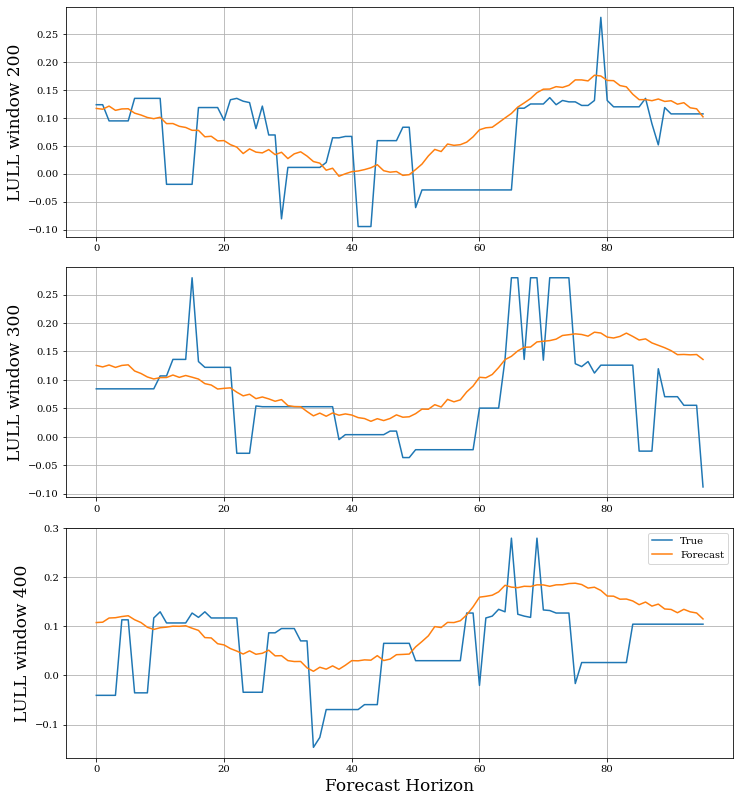

In [14]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 11))
fig.tight_layout()

series = ['HUFL','HULL','LUFL','LULL','MUFL','MULL','OT']
series_idx = 3

for idx, w_idx in enumerate([200, 300, 400]):
  axs[idx].plot(y_true[series_idx, w_idx,:],label='True')
  axs[idx].plot(y_hat[series_idx, w_idx,:],label='Forecast')
  axs[idx].grid()
  axs[idx].set_ylabel(series[series_idx]+f' window {w_idx}', 
                      fontsize=17)
  if idx==2:
    axs[idx].set_xlabel('Forecast Horizon', fontsize=17)
plt.legend()
plt.show()
plt.close()

Finally, we compute the test errors for the two metrics of interest (which are also available in the `trials` object):

$\qquad MAE = \frac{1}{Windows * Horizon} \sum_{\tau} |y_{\tau} - \hat{y}_{\tau}| \qquad$ and $\qquad MSE = \frac{1}{Windows * Horizon} \sum_{\tau} (y_{\tau} - \hat{y}_{\tau})^{2} \qquad$

In [15]:
print('MAE: ', mae(y_hat, y_true))
print('MSE: ', mse(y_hat, y_true))

MAE:  0.26118594
MSE:  0.18341999


In [16]:
#hyperopt_space
print('Forecast Horizon {}'.format(n_time_out))
trials.trials[best_run]['result']['test_losses']

Forecast Horizon 96


{'mae': 0.26118594, 'mse': 0.18341999}

For reference we can check the performance when compared
to previous 'state-of-the-art' long-horizon Transformer-based forecasting methods from the [N-HiTS paper](https://arxiv.org/abs/2201.12886). To recover or improve the paper results try setting `hyperopt_max_evals=30` in [Hyperparameter Tuning](#cell-4).

Mean Absolute Error (MAE):

| Horizon   | N-HiTS       | AutoFormer | InFormer | ARIMA 
|---        |---           |---         |---       |---
|  96       |  0.255❗     |   0.339    |  0.453   | 0.301 
|  192      |  0.305       |   0.340    |  0.563   | 0.345 
|  336      |  0.346       |   0.372    |  0.887   | 0.386 
|  720      |  0.426       |   0.419    |  1.388   | 0.445 

Mean Squared Error (MSE):

| Horizon   | N-HiTS       | AutoFormer | InFormer | ARIMA 
|---        |---           |---         |---       |---
|  96       |  0.176❗     |   0.255    |  0.365   | 0.225 
|  192      |  0.245       |   0.281    |  0.533   | 0.298 
|  336      |  0.295       |   0.339    |  1.363   | 0.370 
|  720      |  0.401       |   0.422    |  3.379   | 0.478 